# Text Mining of Movie Synopsis

<img src='cover.jpg'>

### Hipotezy projektu:
<ul>
<li>Czy klasteryzacja na podstawie odpowiednio wyczyszczonych słów kluczowych będzie się pokrywać z rzeczywistymi gatunkami filmów
<li>Czy najczestsze slowa z podzialem na gatunki roznia sie miedzy soba
</ul>

W naszym projekcie, probowaliśmy wyjaśnić, jak zebrać zestaw dokumentów. Naszym motywującym przykładem jest identyfikacja ukrytych struktur w obrębie streszczeń 100 najlepszych filmów z czterech wybranych kategorii (według listy IMDB): romans, komedia, akcja, fantazja. Analiza obejmuje:

<ul>
<li> tokenizacja i stemming kazdego streszczenia
<li> transformacja korpusu do przestrzeni wektorow uzywajac [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)
<li> obliczenie cosinusowych odleglosci miedzy kazdym dokumentem jako miara podobienstwa
<li> klasteryzacja z wykorzystaniem [k-means algorithm](http://en.wikipedia.org/wiki/K-means_clustering)
<li> klasteryzacja hierarchiczna z uzyciem [Ward clustering](http://en.wikipedia.org/wiki/Ward%27s_method)
<li> wykres dendogramow Warda
</ul>

### Przyszle prace:
<ul>
<li> topic modeling using [Latent Dirichlet Allocation (LDA)](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)
</ul>

### Pipeline:

Po zakonczeniu procesu pozyskiwania danych:

<ul>
<li>[Konkatenacja danych](#Konkatenacja-danych)
<li>[Czyszczenie korpusu](#Czyszczenie-korpusu)
<li>[Utworzenie czterech korpusow wg gatunku](#Utworzenie-czterech-korpusow-wg-gatunku)
<li>[Konwertowanie do listy](#Konwertowanie-do-listy)
<li>[Macierz tf-idf i porownanie opisow filmow](#Macierz-tf-idf-i-porownanie-opisow-filmow)
<li>[Wytrenowanie modelu KMeans](#Wytrenowanie-modelu-KMeans)
<li>[Skalowanie wielowymiarowe](#Skalowanie-wielowymiarow)
<li>[Wizualizacja klasteringu](#Wizualizacja-klasteringu)
<li>[Hierarchiczny klastering](#Hierarchiczny-klastering)
<li>[Bag of words](#Bag-of-words)
<li>[Wordclouds](#Wordclouds)
</ul>

Zaimportowanie potrzebnych bibliotek:

In [1]:
import re
import sys
import nltk
import pandas as pd
import glob
import matplotlib.pyplot as plt
import os
import unicodedata
import spacy

from nltk.tokenize import word_tokenize
from nltk import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.cluster import KMeans

##  Konkatenacja danych

In [2]:
cwd = os.getcwd()
print(cwd)
targetdir = "/home/g.mika/Documents/Untitled Folder/IMDB_keyword_analyzer/movies_txt_storylines/"
filelist = os.listdir(targetdir)
#if file.endswith(".txt"):

rank = list(range(1, 177))
movies_df = pd.DataFrame(index = [rank])
list_ = []

#df_list = [pd.read_table(targetdir + file, encoding='utf-8', engine='python') for file in filelist]

for index, file_ in enumerate(filelist):
    df = pd.read_csv(targetdir + file_,skipinitialspace=True,sep=';;;', header=None)
    df.columns = ['synopses']
    
    file_ = file_.split("/")
    file_ = file_[0].split("_")
    genre = file_[1].split(".")
    genre2 = re.sub('\d+', '', genre[0])
    df['titles'] = file_[0]
    df['genres'] = genre2
    title_prev = ''
    list_.append(df)
    
movies_df = pd.concat(list_)
movies_df

/home/g.mika/Documents/Untitled Folder/IMDB_keyword_analyzer


/home/g.mika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,synopses,titles,genres
0,Three men set out on horseback on a snowy land...,Game of Thrones,action
1,We see their bodies are laid out in a kind of ...,Game of Thrones,action
2,Bran lets fly his arrow and misses wildly.Sudd...,Game of Thrones,action
3,A funeral takes place in the grand cathedral.S...,Game of Thrones,action
4,Cat tells her husband the news of Jon Arryns d...,Game of Thrones,action
5,King Robert of Baratheon and Queen Cersei are ...,Game of Thrones,action
6,They greet each other warmly. Arya is eager to...,Game of Thrones,action
7,"Down there, Robert says Arryn got sick suddenl...",Game of Thrones,action
8,Across the Narrow SeaPrincess Daenerys Targary...,Game of Thrones,action
9,Arya gets removed from the party for flicking ...,Game of Thrones,action


## Czyszczenie korpusu

W tej sekcji przeprowadzono oczyszczenie korpusu w nastepujacej kolejnosci:
<li>Usuniecie znakow specjalnych
<li>NER-y
<li>Usuniecie duzych liter
<li>Tokenizacja
<li>Lematyzacja
<li>Usuniecie stopwords

In [3]:
stop = stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()
# Load spacy model for English: nlp
nlp = spacy.load('en_core_web_sm', tagger=False, parser=False, matcher=False)

movies_df['synopses'] = movies_df['synopses'].map(lambda x: re.sub(r'[^a-zA-Z_0-9\s]', '', str(x)))
#alpha_only = [t for t in token_list if t.isalpha()]
#movies_df['synopses'] = movies_df['synopses'].str.lower()
movies_df['tokens'] = movies_df['synopses'].apply(word_tokenize) 

# Convert list of alpha-numeric tokens into a string: string
string=' '.join(str(r) for v in movies_df['tokens'] for r in v)
# Process whole documents
doc = nlp(string)
# Create a list of NERs
ner=[]
for entity in doc.ents:
    ner.append(entity.text)
    
#flat_list = [item for sublist in movies_df['tokens'].tolist() for item in sublist]
#no_ner = [t.lower() for t in flat_list if t not in ner]
movies_df['tokens'] = movies_df['tokens'].apply(lambda x: [item for item in x if item not in ner])
#movies_df['tokens'] = movies_df['tokens'].str.lower()
# Print unique no-NER tokens
#print(set(no_ner))
#movies_df['tokens'] = movies_df["tokens"].apply(lambda x: [stemmer.stem(y) for y in x])
movies_df['tokens'] = movies_df["tokens"].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x])
#movies_df['tokens'] = movies_df['tokens'].str.lower()
movies_df['tokens'] = movies_df['tokens'].apply(lambda x: [item for item in x if item not in stop])

### Utworzenie czterech korpusow wg gatunku

In [4]:
romance=movies_df.groupby(['genres']).get_group('romance')
comedy=movies_df.groupby(['genres']).get_group('comedy')
fantasy=movies_df.groupby(['genres']).get_group('fantasy')
action=movies_df.groupby(['genres']).get_group('action')

### Konwertowanie do listy

In [5]:
tokens = movies_df['tokens'].tolist()
synopses = movies_df['synopses'].tolist()
titles = movies_df['titles'].tolist()
genres = movies_df['genres'].tolist()

In [6]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [7]:
stemmer = PorterStemmer()

totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [8]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

vocab_frame.head(20)

,words
three,three
men,men
set,set
out,out
on,on
horseback,horseback
on,on
a,a
snowi,snowy
landscap,landscape


## Macierz tf-idf i porownanie opisow filmow

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))
%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

CPU times: user 5.28 s, sys: 7.79 ms, total: 5.29 s
Wall time: 5.28 s
(176, 253)


In [10]:
terms = tfidf_vectorizer.get_feature_names()

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

## Wytrenowanie modelu KMeans

In [12]:
from sklearn.cluster import KMeans

num_clusters = 3
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 436 ms, sys: 0 ns, total: 436 ms
Wall time: 435 ms


In [13]:
movies = {'rank': rank, 'titles': titles, 'genres': genres, 'clusters': clusters, 'synopses': synopses}
movies_clusters_df = pd.DataFrame(movies , index = [rank] ,columns = ['rank', 'titles', 'genres', 'clusters', 'synopses'])

In [14]:
movies_clusters_df.head()
movies_clusters_df.clusters.value_counts()

1    110
0     59
2      7
Name: clusters, dtype: int64

In [23]:
grouped = movies_clusters_df['rank'].groupby(movies_clusters_df['clusters'])
grouped.mean()

clusters
0    98.847458
1    84.390909
2    65.857143
Name: rank, dtype: float64

W kazdym klastrze znalazly sie filmy z kazdego gatunku, co wiecej rozklad gatunkow w klastrach jest relatywnie rownomierny (klaster 0 - po 2 filmy z kazdego gatunku, klaster 1 - tyle samo komedii i romansow i prawie tyle samo filmow akcji i fantasy). Oznacza to, ze klastry utworzone na podstawie streszczen filmow nie odzwierciedlaja rzeczywistego podzialu na gatunki, wbrew temu co moznaby sie spodziewac.

In [16]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :8]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()

Top terms per cluster:

Cluster 0 words: b'his', b'asks', b'has', b'wall', b'young', b'house', b'brother', b'watches',
Cluster 1 words: b'his', b'has', b'tells', b'was', b'says', b'before', b'killed', b'try',
Cluster 2 words: b'like', b'learn', b'just', b'looking', b'this', b'father', b'death', b'was',


/home/g.mika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


## Skalowanie wielowymiarowe

In [17]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [18]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

## Wizualizacja klasteringu

In [24]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'his, asks, has, wall, young, house, brother, watches', 
                 1: 'his, has, tells, was, says, before, killed, try', 
                 2: 'like, learn, just, looking, this, father, death, was'}

In [25]:
%matplotlib inline

/home/g.mika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


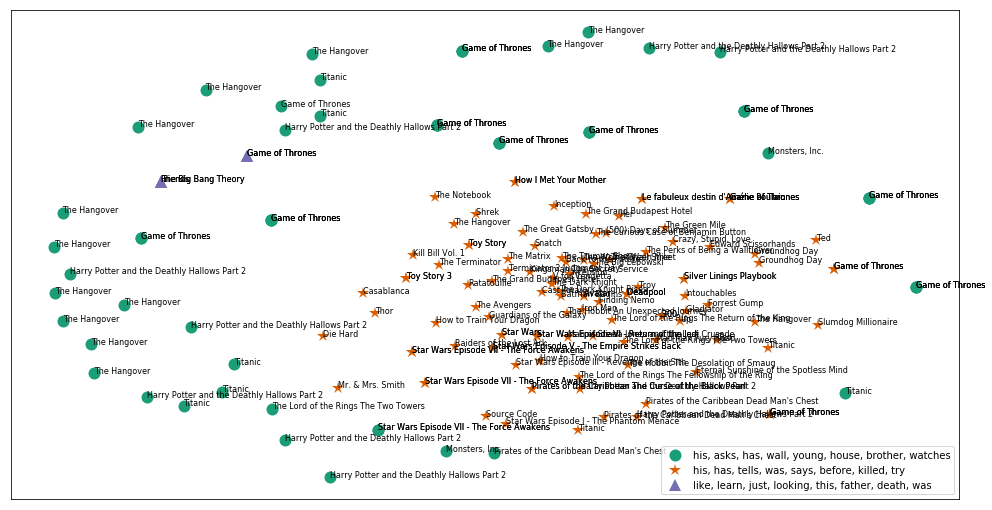

In [26]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')
m = ['o', '*', '^']
# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker=m[name], linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

### Hierarchiczny klastering

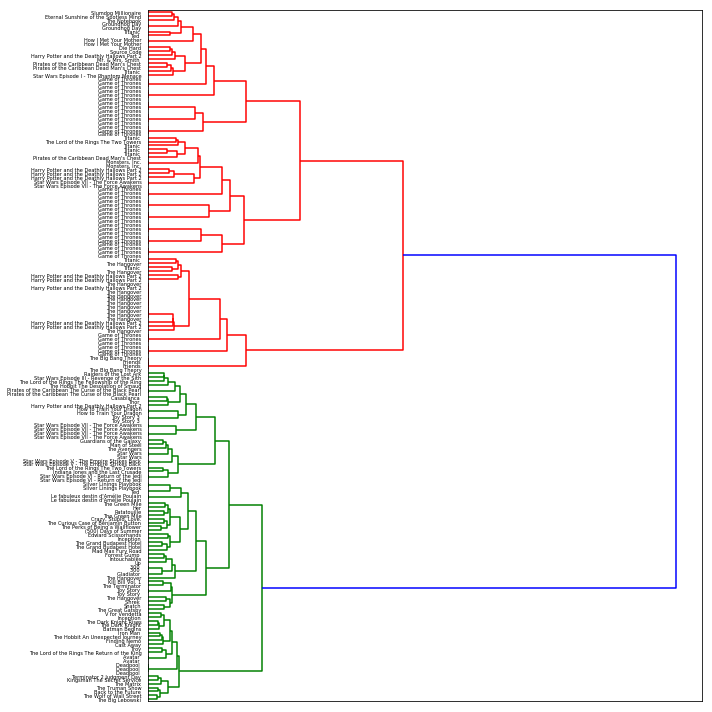

In [22]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(10, 10)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

### Bag of words

In [ ]:
# Count number of occurences of each token
count = Counter(lower_tokens)

# Retain alphabetic words: alpha_only
alpha_only = [t for t in lower_tokens if t.isalpha()]

# Get a list of english stopwords
english_stops = set(stopwords.words('english'))

# Remove all stop words: no_stops
no_stops = [t for t in alpha_only if t not in english_stops]

# Instantiate the WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Lemmatize (group together the inflected forms of a word 
# so they can be analysed as a single item) all tokens into a new list: lemmatized

lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]

# Create the bag-of-words: bow
bow = Counter(lemmatized)

# Print the 10 most common tokens
print(bow.most_common(10))

### NER-y (Named Entity Recognition)

In [9]:
## Named Entity Recognition with spaCy ##

import spacy

# Convert list of alpha-numeric tokens into a string: string 
alphanum = [t for t in tokens if t.isalpha()]
string=' '.join(set(alphanum))

# Load spacy model for English: nlp
nlp = spacy.load('en_core_web_sm', tagger=False, parser=False, matcher=False)

# Process whole documents
doc = nlp(string)

# Create a list of NERs
ner=[]
for entity in doc.ents:
    ner.append(entity.text)
    print(entity.text, entity.label_)

Weaving Gollum PERSON
Anduril PERSON
Beasts NORP
Boromir Gimli PERSON
Rohan GPE
Mindolluin GPE
Rivendell PERSON
Eagles ORG
Realizing Bilbo ORG
Christopher PERSON
Arwen PERSON
Merry PERSON
Brad PERSON
David PERSON
Aragorn Boyd PERSON
Ian PERSON
Army ORG
Shire PERSON
Deep PERSON
Galadriel ORG
Bernard Orthanc PERSON
Karl McKellen PERSON
first ORDINAL
Sam PERSON
Bag PERSON
Pippin ORG
Monaghan PERSON
Fields PERSON
Grey PERSON
trolls War catapulting EVENT
Wood LOC
Isildur GPE
ten CARDINAL
Frodo ORG
Legolas PERSON
Rohirrim NORP
noon TIME
Morgul GPE
Wenham PERSON
Brophy Eldarion ORG
John NazgĂ PERSON
Rosie PERSON
Tyler PERSON
Hugo EVENT
Noble ORG
McLeod Gate ORG
Hill ORG
Andy MĂ PERSON
Bean PERSON
Nazgul PERSON
two CARDINAL
Treebeard PERSON
Havens PERSON
Gondorian NORP
Steward PERSON
Battle PERSON
Ungol PERSON
West LOC
Suffering GPE
Gondorians NORP
Grond GPE
One CARDINAL
half CARDINAL
Straight Middle LOC
Otto PERSON
Liv Sarah PRODUCT
Thomas PERSON
Crack PERSON
Hallows ORG
City PRODUCT
Grima PE

In [13]:
from spacy import displacy
displacy.render(doc, style='ent', jupyter=True)

In [37]:
# Remove all NER: no_ner
no_ner = [t.lower() for t in set(lemmatized) if t not in ner]

# Print unique no-NER tokens
print(set(no_ner))

{'rivendell', 'solace', 'finally', 'forest', 'shatters', 'pain', 'cirith', 'sauron', 'nick', 'faction', 'lied', 'knife', 'terror', 'city', 'merry', 'hooded', 'victory', 'promise', 'edge', 'long', 'show', 'likewise', 'center', 'lava', 'open', 'bag', 'headed', 'massacring', 'abandon', 'collapse', 'honorable', 'wall', 'recognises', 'decides', 'swears', 'ensuing', 'keeping', 'start', 'order', 'belief', 'succumbs', 'dangerous', 'sword', 'try', 'earth', 'rider', 'son', 'captain', 'wound', 'trapped', 'shire', 'legolas', 'enemy', 'affection', 'straight', 'prepares', 'fellowship', 'strangles', 'elrond', 'locate', 'suddenly', 'injury', 'mcleod', 'intervenes', 'rest', 'set', 'see', 'ship', 'force', 'monaghan', 'karl', 'ram', 'solitary', 'rock', 'master', 'mortensen', 'leading', 'squabble', 'true', 'mind', 'hugo', 'reforge', 'saying', 'assuming', 'curiosity', 'orcs', 'refuse', 'soldier', 'rosie', 'recovers', 'death', 'eye', 'birthday', 'last', 'surviving', 'stair', 'ordeal', 'surrounding', 'weavin

### Wordclouds

In [21]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud


def make_word_cloud(input_text, mask, output_file_name, stopwords=None, bckgrd_color = "white", max_words=20000):

    # Read the whole text
    text = open(input_text).read()
    # Load the mask image
    mask = np.array(Image.open(mask))
    # Load stop word list
    stopwords = set(english_stops)
    # Call WordCloud
    wc = WordCloud(background_color=bckgrd_color, max_words=max_words,mask=mask, stopwords=stopwords)

    # Generate word cloud
    wc.generate(text)
    # Write to file
    wc.to_file('cloud_fantasy0.jpg')
    
make_word_cloud(input_text="fantasy0.txt", mask="images.jpg",output_file_name="cloud_fantasy0.jpg", stopwords=english_stops)

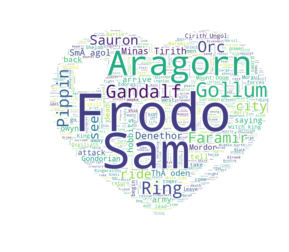

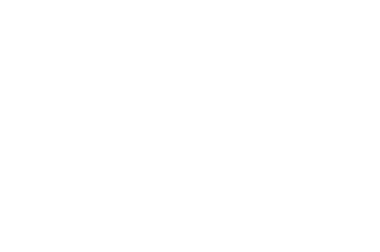

In [40]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud


# Read the whole text.
text = open("fantasy0.txt").read()

# read the mask image
maska = np.array(Image.open("romance_mask.jpg"))

wc = WordCloud(background_color="white", max_words=2000, mask=maska, stopwords=english_stops)
# generate word cloud
wc.generate(text)
wc.to_file("cloud_fantasy0.jpg")

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.axis("off")
plt.show()

In [ ]:
## ROMANCE ##

# Read the whole text.
flat_romance_tocloud = string=' '.join(str(r) for v in romance_tocloud for r in v)
text = flat_romance_tocloud

# read the mask image
maska = np.array(Image.open("romance_mask.jpg"))

wc = WordCloud(width=800, height=400, background_color="white", max_words=2000, mask=maska, stopwords=english_stops)
# generate word cloud
wc.generate(text)
# wc.to_file("cloud_fantasy0.jpg")

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.axis("off")
plt.show()

## ACTION ##

# Read the whole text.
flat_action_tocloud = string=' '.join(str(r) for v in action_tocloud for r in v)
text = flat_action_tocloud

# read the mask image
maska = np.array(Image.open("action_mask.jpg"))

wc = WordCloud(background_color="white", max_words=2000, mask=maska, stopwords=english_stops)
# generate word cloud
wc.generate(text)
# wc.to_file("cloud_fantasy0.jpg")

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.axis("off")
plt.show()


## COMEDY ##

#Read the whole text.
flat_comedy_tocloud = string=' '.join(str(r) for v in comedy_tocloud for r in v)
text = flat_comedy_tocloud

# read the mask image
maska = np.array(Image.open("comedy_mask.jpg"))

wc = WordCloud(background_color="white", max_words=2000, mask=maska, stopwords=english_stops)
# generate word cloud
wc.generate(text)
# wc.to_file("cloud_fantasy0.jpg")

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.axis("off")
plt.show()


## FANTASY ##

#Read the whole text.
flat_fantasy_tocloud = string=' '.join(str(r) for v in fantasy_tocloud for r in v)
text = flat_fantasy_tocloud

# read the mask image
maska = np.array(Image.open("fantasy_mask.jpg"))

wc = WordCloud(background_color="white", max_words=2000, mask=maska, stopwords=english_stops)
# generate word cloud
wc.generate(text)
# wc.to_file("cloud_fantasy0.jpg")

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()

